In [1]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
import time
# from mpi4py import MPI

# comm = MPI.COMM_WORLD
# size = comm.Get_size()
# rank = comm.Get_rank()

fmin = 311.25*10**6 #Hz
fban = 16*10**6 #Hz
freqs = [fmin + i*fban for i in range(6)]
fsample = 2*fban
Period = 1.6*10**(-3) #seconds
PulseWidth = Period/200

fref = fmin#Hz

FileName = "data/test2_caustic_"

# This generates the signal time series. It's some gaussian envelope * random values between +-0.5
def Signal(width=PulseWidth*fsample, length=int(Period*fsample), Noise=0):
    s = np.random.rand(length)-0.5
    t = np.array(range(length))
    t0 = length/2
    envelop = np.exp( -((t-t0)/width)**2 )
    return envelop*s

def PhaseArray(SignalBand, GeoPath, DisPath, Freq):
    LG = len(GeoPath)
    LD = len(DisPath)
    if LG > LD:
        DisPath = np.pad(DisPath,int((LG-LD)/2)+1,'edge')
        DisPath = DisPath[:LG]
    w = Freq + np.array(range(SignalBand))*fban/SignalBand # frequency array, of size fourier transform of signal
    PA = np.outer(w,GeoPath) - np.outer(((fref**2)/w),DisPath)  # the "phase array". it consist of a vertical array of frequencies, each of which has some paths associated.
    return PA

def PhaseFactor(PV):
    phase = np.exp(2*np.pi*(0+1j)*PV )
    return phase

def PathInt(PA): # semi-analytical
    PathInt = []
    #ImCount = []
    fRange, pathRange = np.shape(PA)
    for i in range(fRange):
        Onef = 0
        #image = 0
        IntRange, weight = FindIntRange(PA[i,:])
        for j in IntRange:
            Onef += weight[j] * PhaseFactor(PA[i,j])
            #image += 0
        PathInt += [Onef]
        #ImCount += [image]
    return np.array(PathInt)#, np.array(ImCount)

def FindIntRange(TotPath):
    width = 0.289
    dPath = np.gradient(TotPath)
    window = np.exp(-dPath**2/(2*(width)**2))
    IntRange = np.where(window > 3e-3)[0]
    return IntRange, window

def Scan(begin, end, freq):
    scan = range(begin,end)
    res = np.linspace(-1/2,1/2,6,endpoint='true')[:-1]
    #res = np.linspace(-1/3,1/3,3,endpoint='true')
    lensed = []
    spec = []
    for i in scan:
        dp = dispath[i-(dens*100):i+(dens*100+1)]
        for j in res:
            gp = GeoPath(j)
            PA = PhaseArray(l,gp,dp,freq)
            PI = PathInt(PA)
            s1 = np.fft.irfft(sf*PI)
            # save intensity as well as spectrum
            lensed += [(s1**2).sum()]
            spec += [sf*PI]
        print freq/10**6, i, begin, end, time.clock()
    return np.array(lensed)/norm, np.array(spec)

def DisPath():
    x = np.random.rand(10)*2-1
    y = np.random.rand(10)*2-1
    z = (1+0j)*x + (0+1j)*y
    q = np.array([0]*991)
    z = np.concatenate((z,q))
    z = np.fft.irfft(z)
    amp = 4*10**(-6)
    z = z*amp/np.max(np.abs(z))
    return z

In [2]:
%cd /home/flin/scr/binary-lens
%matplotlib notebook

/mnt/scratch-lustre/flin/binary-lens


In [3]:
dispath = np.load('data/test2Dis.npy')

#increasing density
dens = 4
temp = np.fft.rfft(dispath)
temp = np.concatenate((temp,np.zeros( (dens-1)*1000)))
temp = np.fft.irfft(temp)
temp *= dens
dispath = temp
slope = np.max(np.abs(np.gradient(dispath)))
m = 1.1*slope/(dens*200)
def GeoPath(center):
    gp = m*(np.arange(-dens*100,+dens*100+1)-center)**2
    return gp

In [4]:
s = Signal()
s = s[24000:27000]
sf = np.fft.rfft(s)
l = len(sf)

gp_norm = GeoPath(0)
PA_norm = PhaseArray(l,gp_norm,gp_norm*0,fmin)
PI_norm = PathInt(PA_norm)
s1_norm = np.fft.irfft(sf*PI_norm)
norm = (s1_norm**2).sum()

In [5]:

dispath = dispath[2400-400:3200+400]

<IPython.core.display.Javascript object>


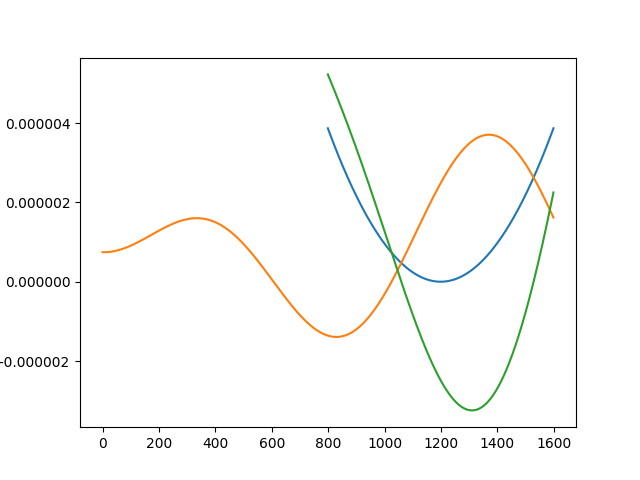

In [11]:
plt.figure()
source = 799
xdata = np.arange(source,source+len(gp_norm))
plt.plot(xdata,gp_norm)
plt.plot(dispath)
plt.plot(xdata,gp_norm-dispath[source:source+len(gp_norm)])